# Multiple Linear Regression



## Preliminaries
As before, we need to start by:
1. Loading the Pandas and Statsmodels libraries
2. Reading the data from a CSV file
3. Fixing the column names using Panda's `rename()` method
4. Converting the "AirEntrain" column to a categorical variable

In [230]:
import pandas as pd
import statsmodels.api as sm

con = pd.read_csv('Data/ConcreteStrength.csv')
con.rename(columns={'Fly ash': 'FlyAsh', 'Coarse Aggr.': "CoarseAgg",
                    'Fine Aggr.': 'FineAgg', 'Air Entrainment': 'AirEntrain', 
                    'Compressive Strength (28-day)(Mpa)': 'Strength'}, inplace=True)
con['AirEntrain'] = con['AirEntrain'].astype('category')
con.head(3)

,No,Cement,Slag,FlyAsh,Water,SP,CoarseAgg,FineAgg,AirEntrain,Strength
0,1,273.0,82.0,105.0,210.0,9.0,904.0,680.0,No,34.990
1,2,163.0,149.0,191.0,180.0,12.0,843.0,746.0,Yes,32.272
2,3,162.0,148.0,191.0,179.0,16.0,840.0,743.0,Yes,35.450


I then define to separate data frames:
1. _Y_ to hold my response variable (the single column "Strength")
2. _X_ to hold my explanatory variables

Note that I have excluded "AirEntrain" at this point because it is categorical.  As we have seen in Excel, SAS Enterprise Guide, and R, including categorical variables in a linear regression requires some additional work.

I complete my _X_ matrix by running the Statsmodels `add_constant()` method, as explained in the tutorial on [linear regression](regression.html).

In [231]:
Y = con['Strength']
X = con[['No',
 'Cement',
 'Slag',
 'FlyAsh',
 'Water',
 'SP',
 'CoarseAgg',
 'FineAgg']]
X = sm.add_constant(X)

## Kitchen sink model
Our tradition is to start with a "kitchen sink" model, which includes all our (numerical) explanatory variables. The Statsmodels OLS output gives us some warnings at the bottom of the output.  We can ignore these at this early stage of the modeling process.

In [232]:
ks = sm.OLS(Y, X)
ks_res =ks.fit()
ks_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Strength   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     56.21
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           1.68e-32
Time:                        10:46:23   Log-Likelihood:                -284.49
No. Observations:                 103   AIC:                             587.0
Df Residuals:                      94   BIC:                             610.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        115.2834    142.786      0.807      0.421    -168.222     398.789
No            -0.0077      0.021     -0.372      0.711      -0.049       0.033
Cement         0.0826      0.047      1.758      0.082      -0.011       0.176
Slag          -0.0225      0.065     -0.346      0.730      -0.152       0.107
FlyAsh         0.0668      0.048      1.380      0.171      -0.029       0.163
Water         -0.2165      0.142     -1.520      0.132      -0.499       0.066
SP             0.2518      0.213      1.181      0.241      -0.172       0.675
CoarseAgg     -0.0479      0.056     -0.857      0.393      -0.159       0.063
FineAgg       -0.0356      0.057     -0.622      0.536      -0.149       0.078
==============================================================================
Omnibus:                        2.168   Durbin-Watson:                   1.715
Prob(Omnibus):                  0.338   Jarque-Bera (JB):                2.183
Skew:                          -0.309   Prob(JB):                        0.336
Kurtosis:                       2.644   Cond. No.                     4.36e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.36e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Categorical explanatory variables
Recall how we have dealt with categorical explanatory variables to this point:
1. **Excel**: We used IF statements and other tricks to create _n_-1 new columns in the spreadsheet (where _n_ is the number of values in the categorical variable)
2. **SAS Enterprise Guide**: We used the recoding functionality in the query builder to add _n_-1 new columns to the data set
3. **R**: We converted the variable to a _factor_ data type and let R construct the _n_-1 dummy columns behind the scenes

In Python, we can use either the manual approach (create a matrix of dummy variables ourselves) or the automatic approach (let the algorithm sort it out behind the scenes).  I am partial to the manual approach because dealing intelligently with categorical variables in real-world data _almost always_ involves significant work.  Specifically: we typically need to change the granularity of the variable to provide more generalizable results.

### Create a matrix of dummy variables
When I say the "manual" approach in Python, I actually mean "quite a bit less manual" than Excel.  Many different libraries in Python provide many different routines for encoding categorical variables.  All of these routines bypass the drudgery of writing IF statements to map from categorical values to (0, 1) values.  Here we will use Pandas's aptly-named `get_dummies()` method.

In this approach, we pass `get_dummies()` a column in a data frame and it creates a full matrix of zero-one values.  In other words, it gives us a matrix with 103 rows (because we have 103 rows in the "Concrete Strength" data set and two columns (because the "AirEntrain" variable has two values: Yes and No).

In [233]:
AirEntrain_d = pd.get_dummies(con['AirEntrain'])
AirEntrain_d

,No,Yes
0,1,0
1,0,1
2,0,1
3,1,0
4,1,0
...,...,...
98,1,0
99,1,0
100,0,1
101,0,1


The "Yes" and "No" column headings are problematic, especially if we have to convert many categorical variables with Yes/No values.  Accordingly, I need to make some changes to the default dummy matrix:
1. I want to use AirEntrain=No as my baseline for the dummy variable.  As such, I need to drop the "No" column from the matrix before passing it to the regression.
2. I like to embed my choice of baseline into the the dummy column names. This makes it easier to interpret the regression coefficients


In [234]:
AirEntrain_d.drop(columns='No', inplace=True)
AirEntrain_d.rename(columns={'Yes': 'AirEntrain_Yes'}, inplace=True)
AirEntrain_d.head(3)

,AirEntrain_Yes
0,0
1,1
2,1


### A slightly more automated version
Not surprisingly, we can cut down the number of steps in this process by passing `get_dummies()` additional arguments:

In [235]:
AirEntrain_d = pd.get_dummies(con['AirEntrain'], prefix='AirEntrain', drop_first=True)
AirEntrain_d.head(3)

,AirEntrain_Yes
0,0
1,1
2,1


### Adding the dummy columns to the existing _X_ matrix

In [236]:
fullX = pd.concat([X, AirEntrain_d['AirEntrain_Yes']], axis=1)
fullX.head()

,const,No,Cement,Slag,FlyAsh,Water,SP,CoarseAgg,FineAgg,AirEntrain_Yes
0,1.0,1,273.0,82.0,105.0,210.0,9.0,904.0,680.0,0
1,1.0,2,163.0,149.0,191.0,180.0,12.0,843.0,746.0,1
2,1.0,3,162.0,148.0,191.0,179.0,16.0,840.0,743.0,1
3,1.0,4,162.0,148.0,190.0,179.0,19.0,838.0,741.0,0
4,1.0,5,154.0,112.0,144.0,220.0,10.0,923.0,658.0,0


### Running the full regression

In [237]:
ks2 = sm.OLS(Y, fullX)
ks2_res = ks2.fit()
ks2_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Strength   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     125.1
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           5.83e-48
Time:                        10:46:23   Log-Likelihood:                -242.38
No. Observations:                 103   AIC:                             504.8
Df Residuals:                      93   BIC:                             531.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             41.5005     95.617      0.434      0.665    -148.375     231.376
No                -0.0173      0.014     -1.251      0.214      -0.045       0.010
Cement             0.0962      0.031      3.063      0.003       0.034       0.159
Slag               0.0157      0.044      0.359      0.720      -0.071       0.102
FlyAsh             0.0869      0.032      2.684      0.009       0.023       0.151
Water             -0.1380      0.095     -1.446      0.151      -0.328       0.051
SP                 0.1902      0.143      1.334      0.186      -0.093       0.473
CoarseAgg         -0.0160      0.037     -0.428      0.669      -0.090       0.058
FineAgg           -0.0021      0.038     -0.053      0.957      -0.078       0.074
AirEntrain_Yes    -6.0683      0.559    -10.848      0.000      -7.179      -4.957
==============================================================================
Omnibus:                        4.217   Durbin-Watson:                   1.637
Prob(Omnibus):                  0.121   Jarque-Bera (JB):                3.635
Skew:                           0.351   Prob(JB):                        0.162
Kurtosis:                       3.594   Cond. No.                     4.37e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.37e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Using R-like formulas
As I mentioned previously, R was used in statistics long before Python was popular.  As a consequence, some of the data science libraries for Python mimic the R way of doing thing.  This makes it much easier for people who know R to transition to Python.  If, however, you do not know R, it just adds a lot of confusion.

Having said this, formula notation in R turns out to be pretty handy.  Instead of defining separate _Y_ and _X_ matrices, you simply pass R a formula of the form "Y ~ X1, X2, ... Xn" and it takes care of the rest.  It turns out that Statsmodels includes a whole library for doing things the R way.  Two things to know:
1. You have to import the statsmodels.formula.api library instead of (or, more typically, in addition to) the statsmodels.api library
2. The method names in the "formula" api are lowercase (e.g., `ols()` instead of `OLS()`

Yes, this is confusing, but you can do things like this:

In [238]:
import statsmodels.formula.api as smf
ksf =  smf.ols(' Strength ~ No + Cement + Slag + Water + CoarseAgg + FlyAsh + SP + FineAgg + AirEntrain', data=con)
ksf_res = ksf.fit()
ksf_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Strength   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     125.1
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           5.83e-48
Time:                        10:46:23   Log-Likelihood:                -242.38
No. Observations:                 103   AIC:                             504.8
Df Residuals:                      93   BIC:                             531.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            41.5005     95.617      0.434      0.665    -148.375     231.376
AirEntrain[T.Yes]    -6.0683      0.559    -10.848      0.000      -7.179      -4.957
No                   -0.0173      0.014     -1.251      0.214      -0.045       0.010
Cement                0.0962      0.031      3.063      0.003       0.034       0.159
Slag                  0.0157      0.044      0.359      0.720      -0.071       0.102
Water                -0.1380      0.095     -1.446      0.151      -0.328       0.051
CoarseAgg            -0.0160      0.037     -0.428      0.669      -0.090       0.058
FlyAsh                0.0869      0.032      2.684      0.009       0.023       0.151
SP                    0.1902      0.143      1.334      0.186      -0.093       0.473
FineAgg              -0.0021      0.038     -0.053      0.957      -0.078       0.074
==============================================================================
Omnibus:                        4.217   Durbin-Watson:                   1.637
Prob(Omnibus):                  0.121   Jarque-Bera (JB):                3.635
Skew:                           0.351   Prob(JB):                        0.162
Kurtosis:                       3.594   Cond. No.                     4.37e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.37e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This is exactly the same formula we used in R for the kitchen sink model.

## Checking for colinearity

### Scatterplot matrix
We can run a scatterplot matrix on our orginal _X_ matrix using Seaborn's handy `pairplot()` method. A nice feature of this presentation is a histogram for each variable. **Note** that this may take a few seconds to generate so you  have to be patient.  

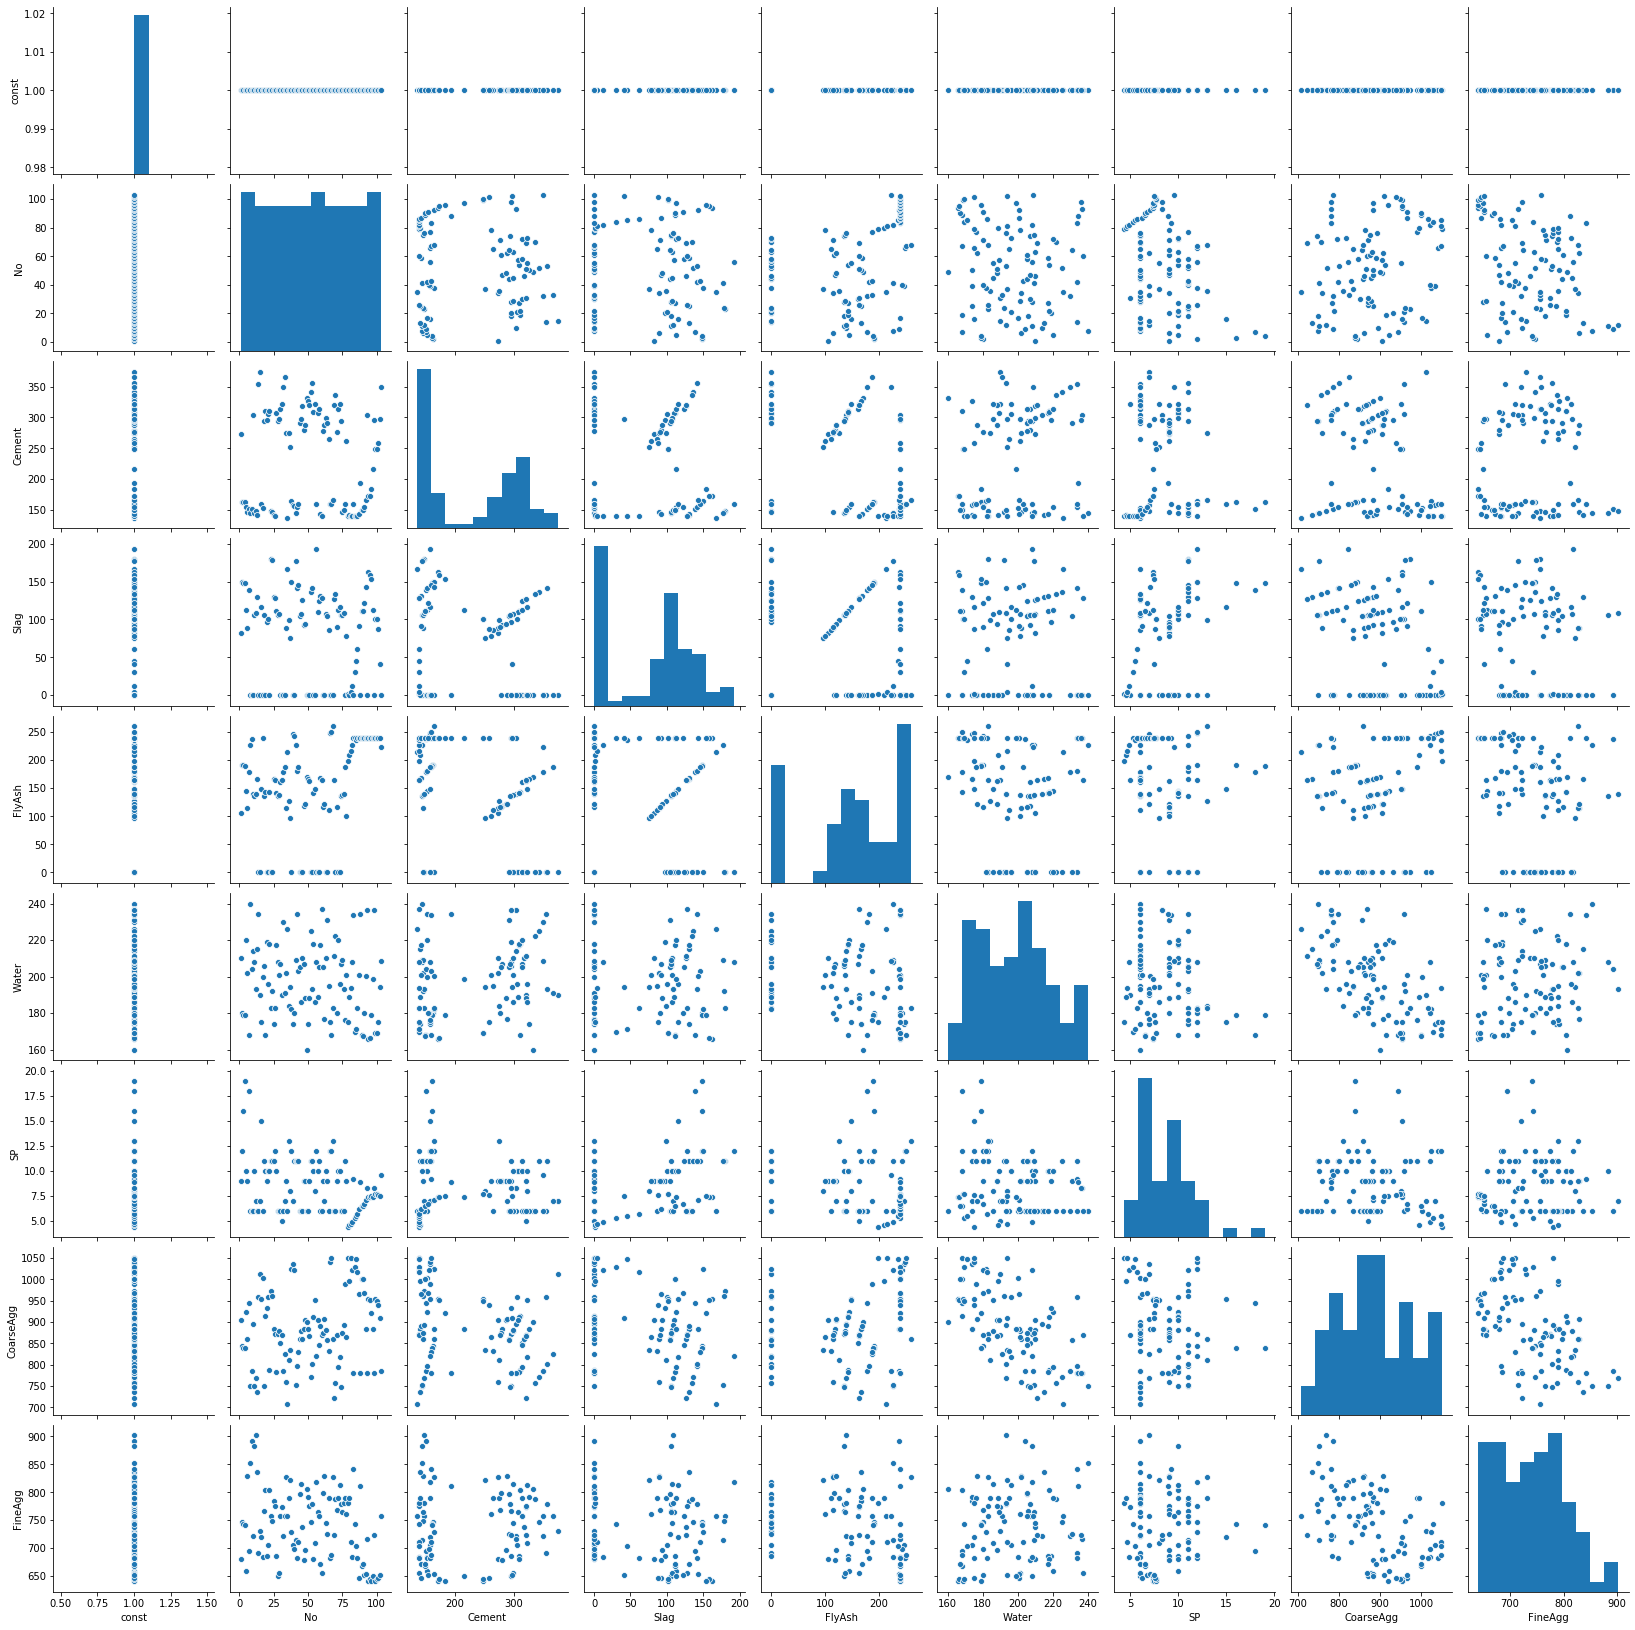

In [239]:
import seaborn as sns
sns.pairplot(X);

### Restricting variables in the scatterplot matrix
With wide data sets (many columns), the scatterplots become unreadable.  Thus, it is often better to restrict the variables in the scatterplot matrix to a named set in order to maximize readability.  Here I have excluded the constant, response variable, and all dummy columns.

A few things that catch my eye in the scatterplot matrix:
1. The "No" variable (experiment number) does not appear to be correlated with any other variable.  That is good news&mdash;we should not expect it to in a well-run experiment.
2. There is some linearity and other weirdness in the relationships between "FlyAsh", "Slag", and "Cement". This suggests problems with the experimental design. Unfortunately, these problems cannot be fixed in the data analysis stage.

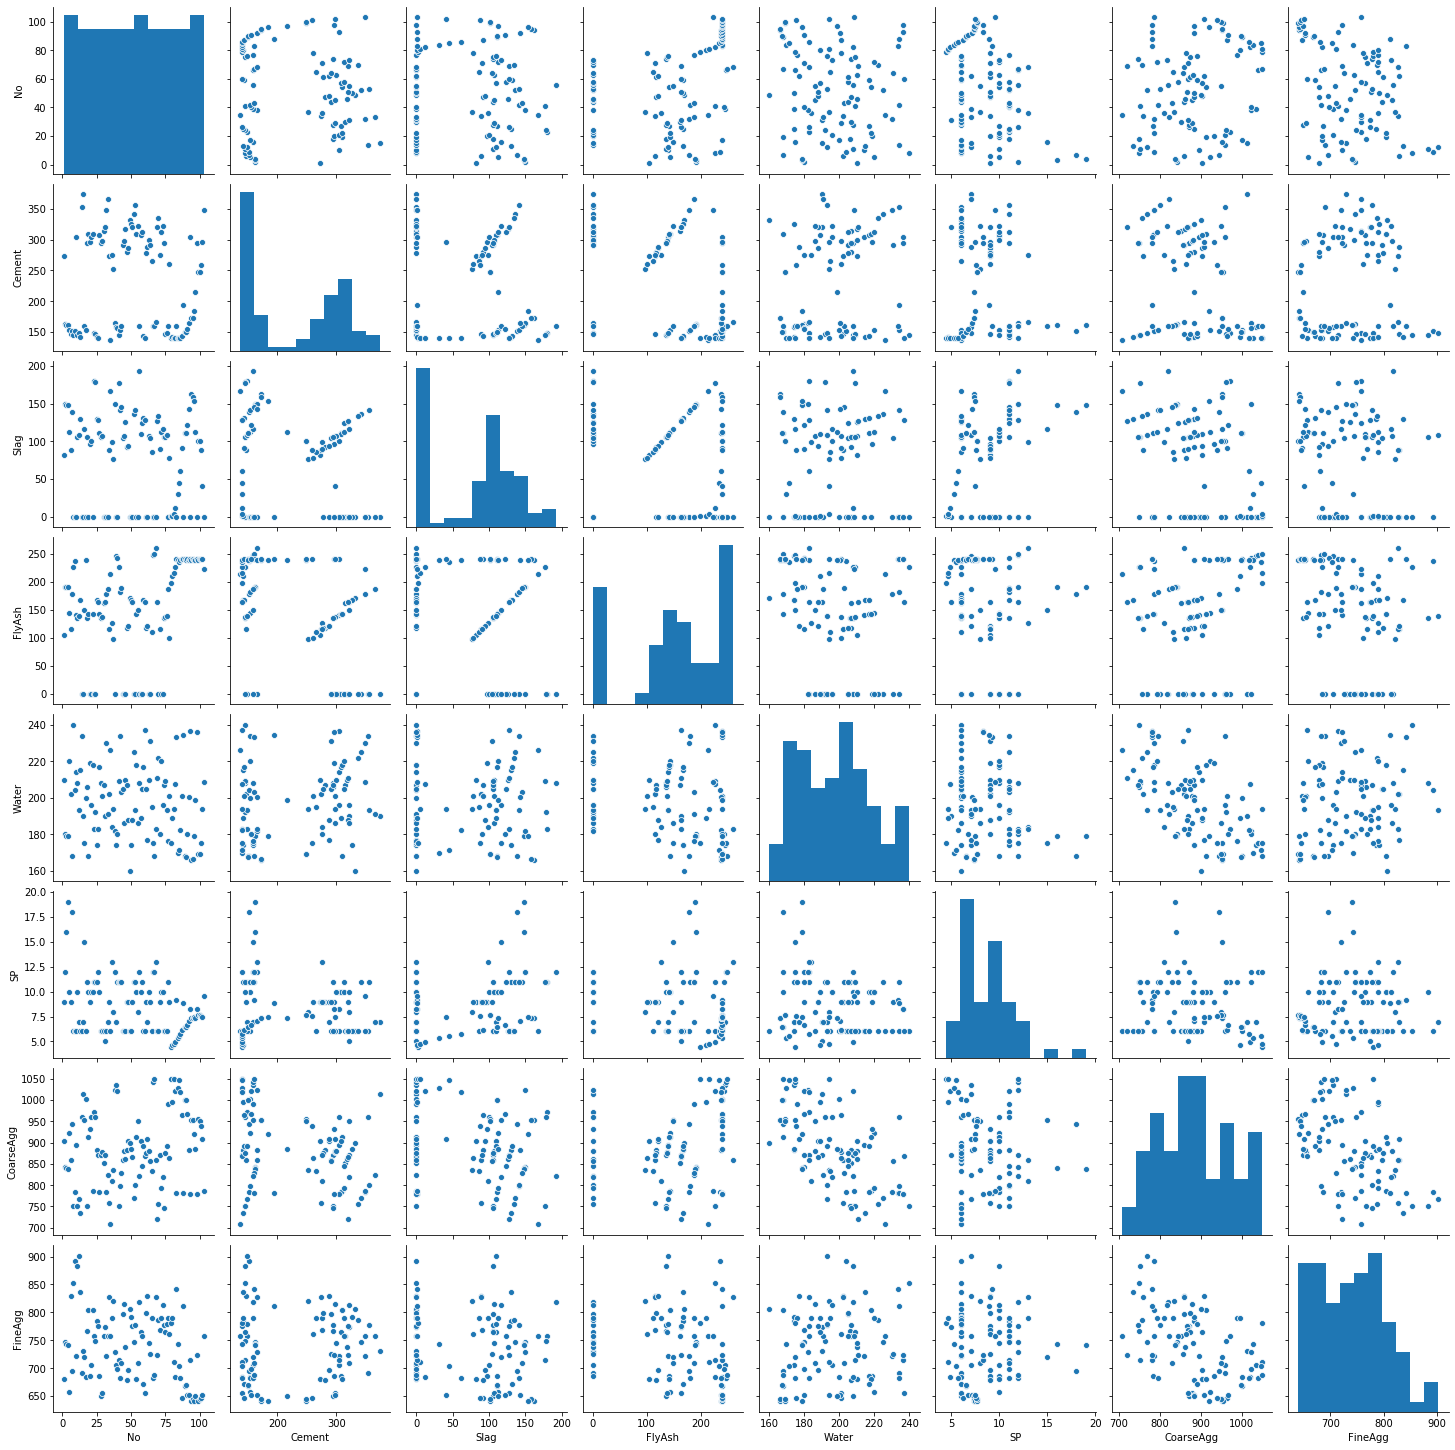

In [240]:
sns.pairplot(X[['No',
 'Cement',
 'Slag',
 'FlyAsh',
 'Water',
 'SP',
 'CoarseAgg',
 'FineAgg']]);

### Correlation matrix
If the scatterplot matrix remain too hard to read, you can always revert to a simple correlation matrix.

In [241]:
round(con.corr(),2)

,No,Cement,Slag,FlyAsh,Water,SP,CoarseAgg,FineAgg,Strength
No,1.00,-0.03,-0.08,0.34,-0.14,-0.33,0.22,-0.31,0.19
Cement,-0.03,1.00,-0.24,-0.49,0.22,-0.11,-0.31,0.06,0.46
Slag,-0.08,-0.24,1.00,-0.32,-0.03,0.31,-0.22,-0.18,-0.33
FlyAsh,0.34,-0.49,-0.32,1.00,-0.24,-0.14,0.17,-0.28,0.41
Water,-0.14,0.22,-0.03,-0.24,1.00,-0.16,-0.60,0.11,-0.22
SP,-0.33,-0.11,0.31,-0.14,-0.16,1.00,-0.10,0.06,-0.02
CoarseAgg,0.22,-0.31,-0.22,0.17,-0.60,-0.10,1.00,-0.49,-0.15
FineAgg,-0.31,0.06,-0.18,-0.28,0.11,0.06,-0.49,1.00,-0.17
Strength,0.19,0.46,-0.33,0.41,-0.22,-0.02,-0.15,-0.17,1.00


## Model refinement
The kitchen sink model is unlikely to be the best model.  At the very least, we need to remove variables that should not be in the model for **methodological** reasons, such as collinearity.  Then, depending on our philosophical view on such things, we can go into data mining mode and attempt to generate the "best" model by removing or adding explanatory variables. Two clarifications:
1. The **best** model is typically defined in terms of the trade-off between goodness of fit (e.g., $R^2$) and model complexity (the number of explanatory variables).  This trade-off provides the rationale for the _adjusted_ $R^2$ measure. Given two models with similar explanatory power, the one with the fewest explanatory variables is deemed better.  
2. **Data mining mode** means we suspend our knowledge about the underlying domain and instead focus on technical measures of explanatory power. In this mode, we keep our theories about cause and effect to ourselves: If the measure indicates a variable has explanatory power, we leave it in the model; if the measure indicates the variable has low explanatory power, we take it out of the model. Many different heuristic measures of explanatory power exist, including the _p_-value of the coefficient and the more sophistical measures (AIC, Mallows Cp) used by SAS and R.

### Manual stepwise refinement
When we did manual stepwise refinement in Excel, our heuristic was to start with the kitchen sink model and remove the variable with the highest _p_-value (probability of zero slope).

If we scroll up to the results of the kitchen sink model, we see that the variable with the highest _p_-value is "FineAgg". If we are using the matrix version of the `OLS()` method, we can drop the column from the _X_ matrix.

In [242]:
X1 = fullX.drop(columns='FineAgg', inplace=False)
mod1 = sm.OLS(Y, X1)
mod1_res = mod1.fit()
mod1_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Strength   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     142.2
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           4.73e-49
Time:                        10:46:58   Log-Likelihood:                -242.38
No. Observations:                 103   AIC:                             502.8
Df Residuals:                      94   BIC:                             526.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             36.4097      8.674      4.197      0.000      19.186      53.633
No                -0.0178      0.011     -1.674      0.097      -0.039       0.003
Cement             0.0978      0.005     18.070      0.000       0.087       0.109
Slag               0.0180      0.006      2.819      0.006       0.005       0.031
FlyAsh             0.0887      0.005     17.367      0.000       0.079       0.099
Water             -0.1330      0.019     -7.131      0.000      -0.170      -0.096
SP                 0.1950      0.109      1.791      0.077      -0.021       0.411
CoarseAgg         -0.0141      0.005     -2.964      0.004      -0.023      -0.005
AirEntrain_Yes    -6.0707      0.555    -10.946      0.000      -7.172      -4.970
==============================================================================
Omnibus:                        4.255   Durbin-Watson:                   1.637
Prob(Omnibus):                  0.119   Jarque-Bera (JB):                3.680
Skew:                           0.352   Prob(JB):                        0.159
Kurtosis:                       3.601   Cond. No.                     3.15e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.15e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We can continue this refinement until all the explanatory variables are significant at some level.  This backstep approach is the simplest method of model refinement.

### Manual refinement in formula mode
Dropping variables in formula mode is a simple matter of removing them from the R-like formula.  Here I have removed "FineAgg":

In [243]:
mod1f =  smf.ols(' Strength ~ No + Cement + Slag + Water + CoarseAgg + FlyAsh + SP + AirEntrain', data=con)
mod1f_res = mod1f.fit()
mod1f_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Strength   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     142.2
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           4.73e-49
Time:                        10:46:59   Log-Likelihood:                -242.38
No. Observations:                 103   AIC:                             502.8
Df Residuals:                      94   BIC:                             526.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            36.4097      8.674      4.197      0.000      19.186      53.633
AirEntrain[T.Yes]    -6.0707      0.555    -10.946      0.000      -7.172      -4.970
No                   -0.0178      0.011     -1.674      0.097      -0.039       0.003
Cement                0.0978      0.005     18.070      0.000       0.087       0.109
Slag                  0.0180      0.006      2.819      0.006       0.005       0.031
Water                -0.1330      0.019     -7.131      0.000      -0.170      -0.096
CoarseAgg            -0.0141      0.005     -2.964      0.004      -0.023      -0.005
FlyAsh                0.0887      0.005     17.367      0.000       0.079       0.099
SP                    0.1950      0.109      1.791      0.077      -0.021       0.411
==============================================================================
Omnibus:                        4.255   Durbin-Watson:                   1.637
Prob(Omnibus):                  0.119   Jarque-Bera (JB):                3.680
Skew:                           0.352   Prob(JB):                        0.159
Kurtosis:                       3.601   Cond. No.                     3.15e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.15e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Automated stepwise refinement
What we are attempting to replicate in automated stepwise refinement is the "model selection method" feature of SAS Enterprise Guide.  Recall that SAS provides several algorithms for determining which explanatory variables to include in the final regression model and which to exclude.

Unfortunately for us, model refinement is conspicuously absent from the popular Python libraries.  My own theory is this:
1. Hardcore statisticians do not belive in iterative model refinement.  Instead, they believe model selection should be guided by a solid understanding of the underlying domain.  In this view, a variable should only be included in a model if there is a _reason_ to included it (if a plausible story can be told about _why_ it should be in the model).
2. The machine learning community is understandably more sympathetic to the "throw everything into the model and let the algoririthm sort it out" approach.  However, this community has no special affinity for ordinary least squares regression&mdash;there are so many other techniques out there that are deemed better/more stable.

The bottom line (in my theory) is that neither the hardcore statistics community nor the machine learning community see iterative refinement of OLS models as worthwhile for real-word modeling.  Accordingly, you should adopt one of the two perspectives above:
1. Use manual model refinement guided by domain knowledge to create a linear regression model that makes sense
2. Build on your new foundation of Python to learn more sophisticated machine learning technique and forget about stepwise refinement of linear regression.

Given this, I have moved the section on stepwise refinement to the end of the lesson.

## Regression diagnostics
As we did in the lesson on [simple regression](regression.html), we can generate our favorite diagnostic plots to determine whether the resulting regression model is valid.

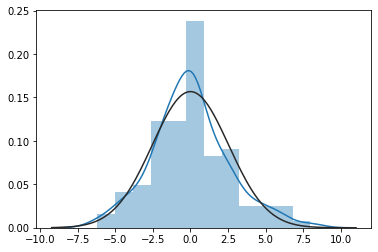

In [244]:
from scipy import stats
sns.distplot(mod1_res.resid, fit=stats.norm);

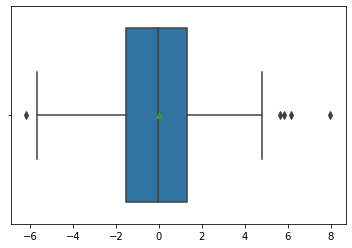

In [245]:
sns.boxplot(mod1_res.resid, showmeans=True);

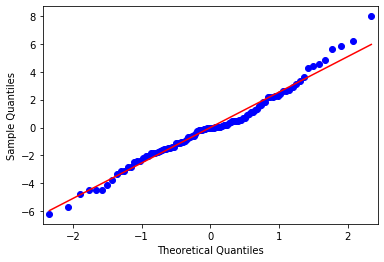

In [246]:
sm.qqplot(mod1_res.resid, line='s');

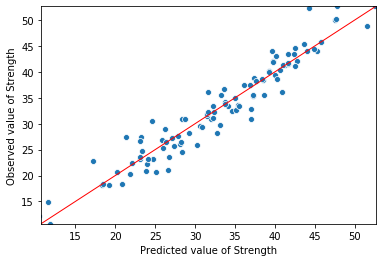

In [247]:
import matplotlib.pyplot as plt
import numpy as np

Y_max = Y.max()
Y_min = Y.min()

ax = sns.scatterplot(mod1_res.fittedvalues, Y)
ax.set(ylim=(Y_min, Y_max))
ax.set(xlim=(Y_min, Y_max))
ax.set_xlabel("Predicted value of Strength")
ax.set_ylabel("Observed value of Strength")

X_ref = Y_ref = np.linspace(Y_min, Y_max, 100)
plt.plot(X_ref, Y_ref, color='red', linewidth=1)
plt.show()

## Standardized regression coefficients
As discussed in the [R tutorials](http://www.sfu.ca/~mjbrydon/tutorials/BAinR/multiregression.html#standardized-regression-coefficients), standardized regression coefficients provide an easy way to estimate effect size that is indepedent of units.

Although estracting standardized coefficients is farily easy in R, we have to be a bit more explicit in Python:
1. Transform the _Y_ and each column of the _X_ matrices into standardize values (_z_-scores) with mean = 0 and standard deviation = 1.0.
2. Run the regression with the standardized inputs.  This provides standardized regression coefficients
3. Extract and display the standardized coefficient

### Creating standardized input matrices
Here, I use the `zscore()` method from Scipy.  The only trick is that `zscore()` returns an array and I prefer to work with Pandas data frames (or series, for single-column data frames).  To get around this, I wrap the `zscore()` call inside the `Series()` constructor.  I pass the constructor the name of the original _Y_ series to keep everything the same.

In [248]:
from scipy import stats
Y_norm = pd.Series(stats.zscore(Y), name=Y.name)
Y_norm.head(3)

0    0.233336
1   -0.061669
2    0.283264
Name: Strength, dtype: float64

The _X_ matrix is a bit trickier because the first column (the "const" column we created above) has zero variance&mdash;recall that is is just a column of 1s.  The definition of _z_-score is $$z = \frac{x - \bar{x}}{S}$$.  If there is no variance, the _z_-score is undefined and everything breaks.  To get around this, I do the following:
1. I create a new data frame called "X1_norm by using the Pandas `loc[]` function to select just a subset of columns. In the first line, I select all rows (:) and all columns where the column name is not equal to "const.
2. I apply the `zscore()` method to the entire "X1_norm" data frame.
3. Since I stripped the constant in the first line, I add it back by recalling the `add_constant()` method
4. I apply the column names from my original "X1" data frame to the new "X1_norm" data frame
5. I perform a quick check to confirm the values for all explanatory variables are normalized with mean = 0 and (population) standard deviation = 1.

In [249]:
X1_norm = X1.loc[:, X1.columns != "const"]
X1_norm = pd.DataFrame(stats.zscore(X1_norm))
X1_norm = sm.add_constant(X1_norm)
X1_norm.columns = X1.columns
check = pd.concat([round(X1_norm.mean(axis=0), 5), round(X1_norm.std(axis=0, ddof=0), 5)], axis=1)
check.columns=["mean", "std dev"]
check

,mean,std dev
const,1.0,0.0
No,-0.0,1.0
Cement,0.0,1.0
Slag,0.0,1.0
FlyAsh,0.0,1.0
Water,-0.0,1.0
SP,0.0,1.0
CoarseAgg,0.0,1.0
AirEntrain_Yes,0.0,1.0


### Running the standardized regression
Once the standardized input matrices are in place, running a standardized regression is no different from running any other regression.  The difference is that we know the coefficients are now expressed  in terms of number of standard deviations rather than kilograms, megapascals, and so on.

In [250]:
modstd = sm.OLS(Y_norm, X1_norm)
modstd_res = modstd.fit()
modstd_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Strength   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     142.2
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           4.73e-49
Time:                        10:47:00   Log-Likelihood:                -13.650
No. Observations:                 103   AIC:                             45.30
Df Residuals:                      94   BIC:                             69.01
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.735e-16      0.028   6.09e-15      1.000      -0.057       0.057
No                -0.0575      0.034     -1.674      0.097      -0.126       0.011
Cement             0.8336      0.046     18.070      0.000       0.742       0.925
Slag               0.1175      0.042      2.819      0.006       0.035       0.200
FlyAsh             0.8180      0.047     17.367      0.000       0.724       0.911
Water             -0.2903      0.041     -7.131      0.000      -0.371      -0.209
SP                 0.0591      0.033      1.791      0.077      -0.006       0.125
CoarseAgg         -0.1342      0.045     -2.964      0.004      -0.224      -0.044
AirEntrain_Yes    -0.3282      0.030    -10.946      0.000      -0.388      -0.269
==============================================================================
Omnibus:                        4.255   Durbin-Watson:                   1.637
Prob(Omnibus):                  0.119   Jarque-Bera (JB):                3.680
Skew:                           0.352   Prob(JB):                        0.159
Kurtosis:                       3.601   Cond. No.                         4.11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Tornado diagram
Once we have the regression results, we can extract the coefficients using the `params` property and graph the standardized coefficients.  The only trick to getting a tornado diagram is that the coefficients have to be sorted in descending order by the _absolute value_ of the coefficient.  I resort to a bity of Python trickery to get the items in the desired order.  As before, we see that "Cement" and "FlyAsh" are the most important drivers of concrete strength.

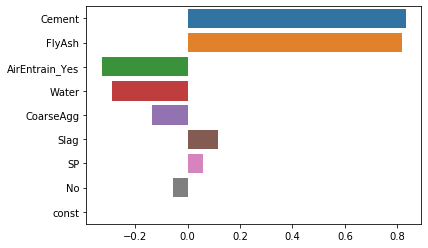

In [251]:
coeff = modstd_res.params
coeff = coeff.iloc[(coeff.abs()*-1.0).argsort()]
sns.barplot(coeff.values, coeff.index, orient='h');

## Stepwise refinement: an aside


It is certainly possible to code your own stepwise refinement procedure in Python: if you Google hard enough, you will find lots of these.  Finding an easy-to-use library version of R's `step()` function is more challenging.  The one I did find belongs to the MLxtend library. It is not a standard install you you might have to download it before you can run the `import` commands.  Installation instructions are [here](http://rasbt.github.io/mlxtend/installation/) if you really must try it out.

### Create a sklearn kitchen sink model
The MLxtend library wraps around the sklearn `LinearRegression` function rather than the Statsmodels version we have been using so far.  Thus, we have to create a new linear regression object.  Unlike Statsmodel, sklearn's version does not require a column of 1s for the constant.  As such, have to create a new explanatory variable matrix without the "const" column:

In [252]:
X2 = fullX
X2.drop("const", axis=1, inplace=True)
X2.head(3)

,No,Cement,Slag,FlyAsh,Water,SP,CoarseAgg,FineAgg,AirEntrain_Yes
0,1,273.0,82.0,105.0,210.0,9.0,904.0,680.0,0
1,2,163.0,149.0,191.0,180.0,12.0,843.0,746.0,1
2,3,162.0,148.0,191.0,179.0,16.0,840.0,743.0,1


Then we load the requried libraries.  I had to install the mlxtend package first.  

In [253]:
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

We can now create an sklearn regression model and confirm it works

In [254]:
mod = LinearRegression()
mod.fit(X2,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

The resulting model is identical to our kitchen sink model from above.  We can verify by manually patching together a table of results (Sklearn's regression routine does not have the tidy summary provided by the Statsmodels version).

In [255]:
coef = pd.concat([pd.Series(X2.columns), pd.Series(mod.coef_)], axis=1)
coef.columns=["variable", "coefficient"]
coef

,variable,coefficient
0,No,-0.017346
1,Cement,0.096195
2,Slag,0.015681
3,FlyAsh,0.086950
4,Water,-0.138011
5,SP,0.190158
6,CoarseAgg,-0.016038
7,FineAgg,-0.002053
8,AirEntrain_Yes,-6.068252


### Running the refinement algorithm

The method we are using from the mlxtend library is called "sequential feature selector" (SFS).  We set up an SFS object and pass it a link to our regression model "mod" and some other parameters.  Running `fit()` creates a sequence of model versions created using standard backstep refinement (other approaches are possible by setting the `forward` and `floating` parameters.)

In [256]:
sfs = SFS(mod,
         k_features='best',
         forward=False,
         floating=False,
         scoring='r2',
         cv=30)

sfs = sfs.fit(X2,Y)

### Viewing the iterations
We can wrap the output from the SFS object in a Pandas data frame and print the result.  Note that the data frame is sorted by the number of variables in the model, not the backstep sequence.  The model with eight variables has the highest "avg_score" and lowest "std_err".

In [257]:
pd.DataFrame.from_dict(sfs.get_metric_dict(confidence_interval=0.95)).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
9,"(0, 1, 2, 3, 4, 5, 6, 7, 8)","[0.5998230505243045, 0.8609825359671663, 0.776...",0.482171,"(No, Cement, Slag, FlyAsh, Water, SP, CoarseAg...",0.249123,0.656901,0.121983
8,"(0, 1, 2, 3, 5, 6, 7, 8)","[0.7198251274370645, 0.8714981991943233, 0.754...",0.538054,"(No, Cement, Slag, FlyAsh, SP, CoarseAgg, Fine...",0.174763,0.460825,0.085573
7,"(1, 2, 3, 5, 6, 7, 8)","[0.36909818696153074, 0.8029635284896328, 0.88...",0.489133,"(Cement, Slag, FlyAsh, SP, CoarseAgg, FineAgg,...",0.193566,0.510403,0.0947795
6,"(1, 2, 3, 6, 7, 8)","[-0.8836565141299142, 0.706855501290562, 0.793...",0.383902,"(Cement, Slag, FlyAsh, CoarseAgg, FineAgg, Air...",0.234757,0.619018,0.114949
5,"(1, 2, 3, 7, 8)","[-1.069902143989971, 0.7714511447380334, 0.721...",0.203047,"(Cement, Slag, FlyAsh, FineAgg, AirEntrain_Yes)",0.312601,0.824281,0.153065
4,"(1, 2, 3, 8)","[-1.4776700426094105, 0.7791381638911106, 0.97...",0.1767,"(Cement, Slag, FlyAsh, AirEntrain_Yes)",0.364705,0.961673,0.178578
3,"(1, 3, 8)","[-2.851586980465301, 0.7005985979007635, 0.857...",-0.118087,"(Cement, FlyAsh, AirEntrain_Yes)",0.610482,1.60975,0.298923
2,"(1, 3)","[-3.062125555844749, 0.2731746363441382, 0.902...",-0.732105,"(Cement, FlyAsh)",0.797207,2.10211,0.390353
1,"(1,)","[-3.449038765590842, 0.011736536060135583, 0.5...",-3.40673,"(Cement,)",2.04263,5.38611,1.00018


### Picking the best model visually
MLxtend includes a handy plot for visualizing the best model. As in SAS Enterprise Guide, we are looking for the model with the highest score.  Again, it appears the model with 8 variables is slightly better than some of the other models. 

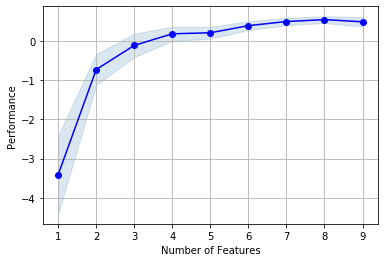

In [258]:
plot_sfs(sfs.get_metric_dict(), kind='std_err')
plt.grid()
plt.show()

### Viewing the best model
We can access the model with 8 variables using 8 as an index (as in the data frame presentation above). We can further narrow down on variable names in the best model:

In [259]:
sfs.subsets_[8].get('feature_names')

('No',
 'Cement',
 'Slag',
 'FlyAsh',
 'SP',
 'CoarseAgg',
 'FineAgg',
 'AirEntrain_Yes')

Interestingly, this backstep algorithm dropped the variable "Water" whereas we dropped "FineAgg" in the manual approach.  R's `step()` function also dropped "FineAgg" first.  Divergent results such as this are part of the reason some in the machine learning community do not like stepwise refinement of linear regression models.  However, they remain interesting for teaching purposes. 